In [1]:
import numpy as np
%matplotlib inline
import pprint

In [2]:
# import pymatgen.core

In [3]:
import pandas as pd
import pathlib

In [4]:
# current working directory
print(pathlib.Path().absolute())

/home/samariam/projects/chemheuristics/reports/mse_poster


In [5]:
# crysdf = pd.read_csv('/home/samariam/projects/chemheuristics/qm9tut/res_df/poster_iter50ep10.csv', index_col=0)

In [6]:
crysdf = pd.read_pickle('/home/samariam/projects/chemheuristics/qm9tut/res_df/poster_iter68_100ep15')

In [7]:
crysdf.head(2)

,crystal_id,material_id,theoretical,formation_energy_per_atom,e_above_hull,atoms,target_pd,targets,pred_0,pred_score0,...,pred_95,pred_score95,pred_96,pred_score96,pred_97,pred_score97,pred_98,pred_score98,pred_99,pred_score99
0,1580,mp-1287184,True,-2.084745,0.022329,"(Atom('O', [-3.496049128734, 1.243670385826500...",0,{'synth': [0]},NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1177,mp-19352,False,-2.436391,0.000000,"(Atom('K', [0.0, 0.0, 3.659167], magmom=-0.0, ...",1,{'synth': [1]},NaN,NaN,...,NaN,NaN,1.0,"{'synth': [tensor(1.5913, grad_fn=<UnbindBackw...",NaN,NaN,0.0,"{'synth': [tensor(-1.3778, grad_fn=<UnbindBack...",NaN,NaN


In [8]:
crysdf = crysdf[crysdf.formation_energy_per_atom>-10]   #dropping outlier from outdated database.

In [9]:
pred_columns = []
score_columns = []
num_iter = 50
epoch_num = 10
for it in range(num_iter):
    pred_col_name = 'pred_'+str(it)
    pred_columns.append(pred_col_name)
    
    score_col_name = 'pred_score'+str(it)
    score_columns.append(score_col_name)

Preds = crysdf[pred_columns]

In [10]:
def scoreFunc(x):
    iter_num = sum(x.notna())
    if iter_num == 0:
        return np.nan, iter_num
    res = x.sum()
    score = res/iter_num
    return score, iter_num

In [11]:
crysdf['Preds'] = Preds.apply(scoreFunc, axis=1)

crysdf[['Preds', 'iter_num']] = crysdf.Preds.tolist()

res_df = crysdf[crysdf.Preds.notna()].drop(columns=[*pred_columns,*score_columns])  #selecting data with prediction values

experimental_df = res_df[res_df.target_pd==1]
theoretical_df = res_df[res_df.target_pd==0]

# %%
true_positive_rate = sum(experimental_df.Preds>=.5)/experimental_df.shape[0]
unlabeled_synth_frac = sum(theoretical_df.Preds>=.5)/theoretical_df.shape[0]

In [12]:
print('Our true positive rate is {:.1f}% after {} iterations of {} epochs.'.format(true_positive_rate*100, num_iter, epoch_num))

Our true positive rate is 93.6% after 50 iterations of 10 epochs.


In [13]:
unlabeled_synth_frac

0.02300824175824176

In [14]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [15]:
edf = experimental_df.copy()
del experimental_df

In [16]:
tdf = theoretical_df.copy()
del theoretical_df

In [17]:
# edf.head(2)
# tdf.head(2)

In [18]:
edf['classPred'] = edf.Preds.map(lambda x: 1 if x>.5 else 0)
tdf['classPred'] = tdf.Preds.map(lambda x: 1 if x>.5 else 0)

In [19]:
figpath = "reports/mse_poster/"

In [20]:
figpath

'reports/mse_poster/'

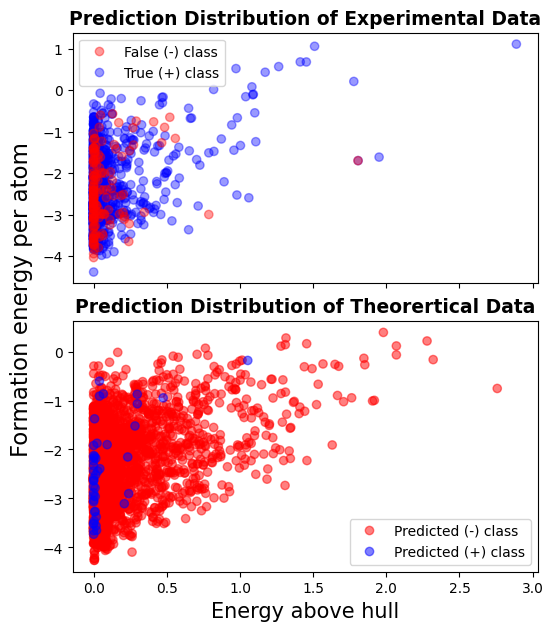

In [43]:
data_classes_e = ['False (-) class', 'True (+) class']
data_classes_t = ['Predicted (-) class', 'Predicted (+) class']

colors = ListedColormap(['r','b'])
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6,7))

scatter  = ax1.scatter(edf.sort_values("Preds", ascending=False).e_above_hull, 
            edf.sort_values("Preds", ascending=False).formation_energy_per_atom,
            c=edf.sort_values("Preds", ascending=False).classPred, 
            cmap = colors,alpha = .4)
ax1.legend(handles=scatter.legend_elements()[0], labels=data_classes_e)

ax1.set_title('Prediction Distribution of Experimental Data', fontsize=13.5, fontweight='bold')
plt.tick_params('x', labelbottom=False);

ax2 = plt.subplot(212,  sharex=ax1,)
scatter  = plt.scatter(tdf.sort_values("Preds", ascending=True).e_above_hull, 
            tdf.sort_values("Preds", ascending=True).formation_energy_per_atom,
            c=tdf.sort_values("Preds", ascending=True).classPred, 
            cmap = colors,alpha = .5)
ax2.legend(handles=scatter.legend_elements()[0], labels=data_classes_t)

ax2.set_xlabel('Energy above hull', fontsize=15)
# ax2.set_ylabel('Formation energy per atom', fontsize=12)
ax2.set_title('Prediction Distribution of Theorertical Data', fontsize=13.5, fontweight='bold');

plt.subplots_adjust(hspace=.15)
fig.text(0.04, 0.5, 'Formation energy per atom', ha='center', va='center',
         rotation='vertical', fontsize=16.5);

# plt.savefig('energies_labels_double.jpg', format='jpg',
plt.savefig('energies_labels_double_100epoch.jpg', format='jpg',
            bbox_inches='tight',dpi=400);


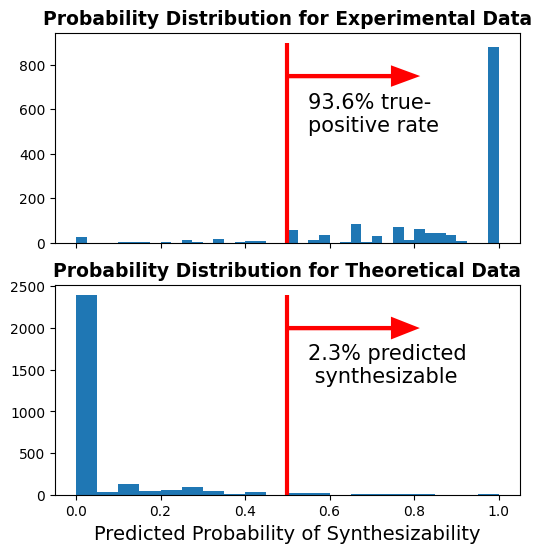

In [44]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6,6))

ax1.hist(edf.Preds, bins=40)
# edf.Preds.hist(bins=40)
ax1.set_title('Probability Distribution for Experimental Data', fontsize=13.5, fontweight='bold')
ax1.vlines(.5, 0,900, 'r',linewidth=3)
ax1.arrow(.5,750,.3,0, linewidth=3, color ='r', length_includes_head=True,
          head_width=70, head_length=0.05)
ax1.text(.55,500, '{:.1f}% true- \npositive rate'.format(true_positive_rate*100), fontsize = 15);


plt.xlabel('Predicted Probability of Synthesizability', fontsize=14)

ax2.hist(tdf.Preds,bins=20)
ax2.vlines(.5, 0,2400, 'r',linewidth=3)
ax2.arrow(.5,2000,.3,0, linewidth=3, color ='r', length_includes_head=True,
          head_width=200, head_length=0.05)
ax2.set_title('Probability Distribution for Theoretical Data', fontsize=13.5,fontweight='bold')
ax2.text(.55,1350, '{:.1f}% predicted \n synthesizable'.format(unlabeled_synth_frac*100), fontsize = 15);


# plt.savefig('prob_dist_double.jpg',format='jpg',
plt.savefig('prob_dist_double_100epoch.jpg',format='jpg',
            bbox_inches='tight',dpi=400);


In [32]:
crysdf[crysdf.e_above_hull>2.5]

,crystal_id,material_id,theoretical,formation_energy_per_atom,e_above_hull,atoms,target_pd,targets,pred_0,pred_score0,...,pred_46,pred_score46,pred_47,pred_score47,pred_48,pred_score48,pred_49,pred_score49,Preds,iter_num
708,1007,mp-654812,False,1.113001,2.888736,"Atoms(symbols='CdCO3', pbc=True, cell=[[3.9797...",1,{'synth': array([1])},NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4
1665,1799,mvc-13391,True,-0.753913,2.758052,"Atoms(symbols='Ti2O4', pbc=True, cell=[[1.7227...",0,{'synth': array([0])},NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,"{'synth': tensor([-3.7746], grad_fn=<SqueezeBa...",NaN,NaN,0.3,10


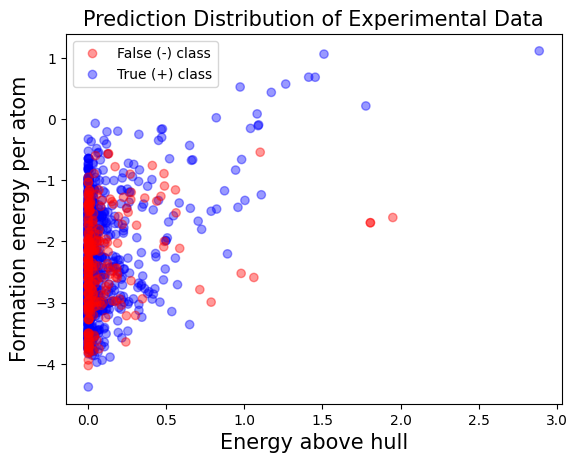

In [ ]:
data_classes = ['False (-) class', 'True (+) class']
colors = ListedColormap(['r','b'])
scatter  = plt.scatter(edf.sort_values("Preds", ascending=False).e_above_hull, 
            edf.sort_values("Preds", ascending=False).formation_energy_per_atom,
            c=edf.sort_values("Preds", ascending=False).classPred, 
            cmap = colors,alpha = .4)
plt.legend(handles=scatter.legend_elements()[0], labels=data_classes)
# plt.colorbar()

plt.xlabel('Energy above hull', fontsize=15)
plt.ylabel('Formation energy per atom', fontsize=15)
plt.title('Prediction Distribution of Experimental Data', fontsize=15);
# plt.savefig(figpath+'pded.jpg', format='jpg',
#             bbox_inches='tight',dpi=300);


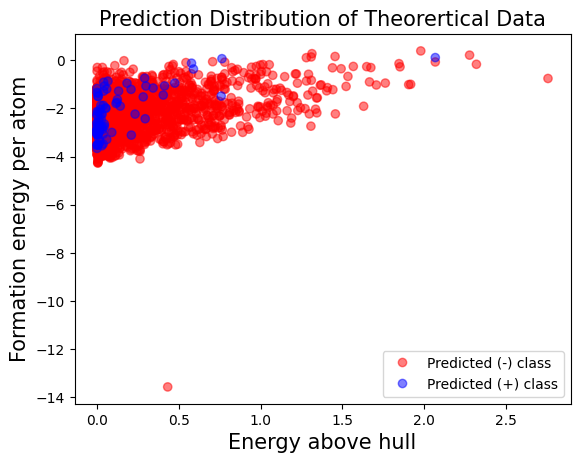

In [22]:
data_classes = ['Predicted (-) class', 'Predicted (+) class']
colors = ListedColormap(['r','b'])
scatter  = plt.scatter(tdf.sort_values("Preds", ascending=True).e_above_hull, 
            tdf.sort_values("Preds", ascending=True).formation_energy_per_atom,
            c=tdf.sort_values("Preds", ascending=True).classPred, 
            cmap = colors,alpha = .5)
plt.legend(handles=scatter.legend_elements()[0], labels=data_classes)
# plt.colorbar()
plt.xlabel('Energy above hull', fontsize=15)
plt.ylabel('Formation energy per atom', fontsize=15)
plt.title('Prediction Distribution of Theorertical Data', fontsize=15);
# plt.savefig(figpath+'pdtd.jpg', format='jpg',
#             bbox_inches='tight',dpi=300);


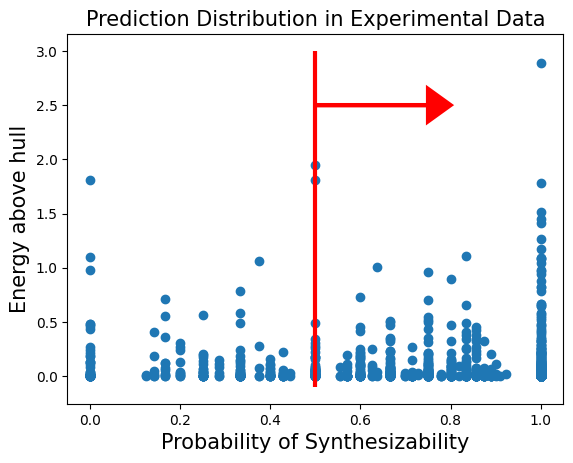

In [23]:
plt.scatter(edf.Preds, edf.e_above_hull)
plt.vlines(.5, -0.1,3, 'r',linewidth=3)
plt.arrow(.5,2.5,.3,0, linewidth=3, color ='r', length_includes_head=True,
          head_width=.3, head_length=0.05)
plt.ylabel('Energy above hull', fontsize=15)
plt.xlabel('Probability of Synthesizability', fontsize=15)
plt.title('Prediction Distribution in Experimental Data', fontsize=15);
# plt.savefig(figpath+'pdede.jpg', format='jpg',
#             bbox_inches='tight',dpi=300);


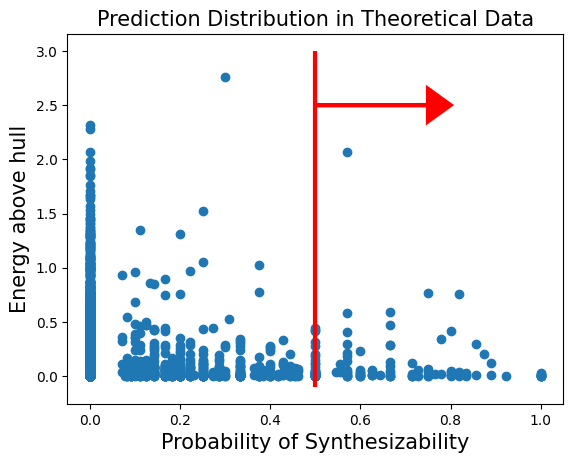

In [24]:
plt.scatter(tdf.Preds, tdf.e_above_hull)
plt.vlines(.5, -0.1,3, 'r',linewidth=3)
plt.arrow(.5,2.5,.3,0, linewidth=3, color ='r', length_includes_head=True,
          head_width=.3, head_length=0.05)
plt.ylabel('Energy above hull', fontsize=15)
plt.xlabel('Probability of Synthesizability', fontsize=15)
plt.title('Prediction Distribution in Theoretical Data', fontsize=15);
# plt.savefig(figpath+'pdtde.jpg', format='jpg',
#             bbox_inches='tight',dpi=300);


Text(0.5, 0, 'Probability of Synthesizability')

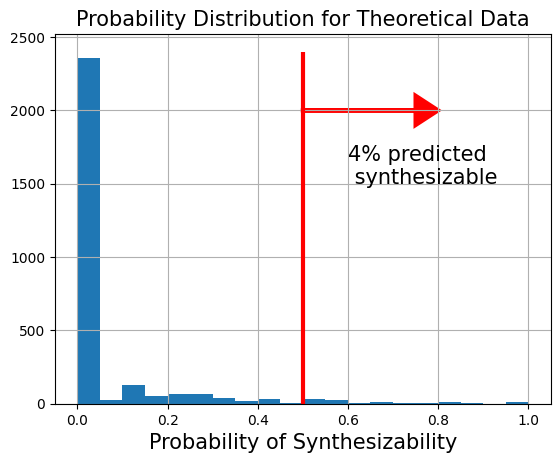

In [25]:
tdf.Preds.hist(bins=20)
plt.vlines(.5, 0,2400, 'r',linewidth=3)
plt.arrow(.5,2000,.3,0, linewidth=3, color ='r', length_includes_head=True,
          head_width=200, head_length=0.05)
plt.title('Probability Distribution for Theoretical Data', fontsize=15)
plt.text(.6,1500, '4% predicted \n synthesizable', fontsize = 15);
plt.xlabel('Probability of Synthesizability', fontsize=15)
# plt.savefig(figpath+'pdtdhist.jpg',format='jpg',
#             bbox_inches='tight',dpi=300);


Text(0.5, 0, 'Probability of Synthesizability')

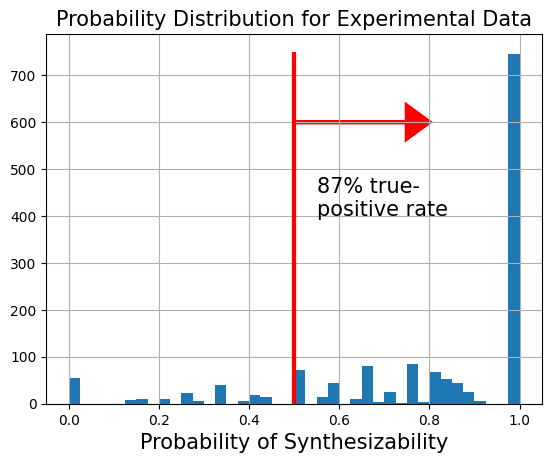

In [26]:
edf.Preds.hist(bins=40)
plt.title('Probability Distribution for Experimental Data', fontsize=15)
plt.vlines(.5, 0,750, 'r',linewidth=3)
plt.arrow(.5,600,.3,0, linewidth=3, color ='r', length_includes_head=True,
          head_width=70, head_length=0.05)
plt.text(.55,400, '87% true- \npositive rate', fontsize = 15);
plt.xlabel('Probability of Synthesizability', fontsize=15)
# plt.savefig(figpath+'pdedhist.jpg',format='jpg',
#             bbox_inches='tight',dpi=300);
